# Straightforward PyTorch implementation of CycleGAN

This tutorial assumes that you have implemented some basic projects in PyTorch and you know what you're doing. If not, check out this link: https://github.com/jcjohnson/pytorch-examples


Have fun implementing this. PM me your results on reddit: u/PhonyPhantom

In [1]:
#import a bunch of stuff

import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#storing the names of your images and paintings in a list

dir = '/data/datasets/monet2photo'
train_paintings_dir = dir + '/trainA/'
train_photos_dir = dir + '/trainB/'

paintings_addr = [train_paintings_dir+i for i in os.listdir(train_paintings_dir)]
photos_addr = [train_photos_dir+i for i in os.listdir(train_photos_dir)]

In [3]:
#Preprocessing data so that every value in the image array is between -1 and 1. 

def create_train_sets(paintings_addr, photos_addr):
    
    X_train, Y_train = np.zeros((1072, 3, 128, 128), dtype=np.float32), np.zeros((6287, 3, 128, 128), dtype=np.float32)
    
    for i in xrange(len(paintings_addr)):
        temp_np = np.asarray(Image.open(paintings_addr[i]).resize((128, 128), Image.ANTIALIAS))  #resizing the image to 128x128
        X_train[i] = temp_np.transpose(2, 0, 1)
        X_train[i] /= 255
        X_train[i] = X_train[i] * 2 -  1
        
    for i in xrange(len(photos_addr)):
        temp_np = np.asarray(Image.open(photos_addr[i]).resize((128, 128), Image.ANTIALIAS))
        Y_train[i] = temp_np.transpose(2, 0, 1)
        Y_train[i] /= 255
        Y_train[i] = Y_train[i] * 2 -  1
    
    return X_train, Y_train

In [4]:
X_train, Y_train = create_train_sets(paintings_addr, photos_addr)  

In [ ]:
#Saving is optional
np.save('X_train', X_train)
np.save('Y_train', Y_train)

In [ ]:
#Loading saved npy files
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

In [5]:
X_tensor = torch.from_numpy(X_train)                #Creating Tensors which will later be wrapped into variables
Y_tensor = torch.from_numpy(Y_train)

Unlike the paper, I use two discriminators per generator as you will see later. This discriminator below is not a part of PatchGAN, it is just a simple discriminator to judge the image as a whole

In [6]:
class discriminator_nonpatch(nn.Module):
    def __init__(self):
        super(discriminator_nonpatch, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=6, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return Fn.sigmoid(x)

This one, however, is part of the PatchGAN which takes 70x70 images as input

In [7]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return Fn.sigmoid(x)

Read the paper's appendix once. This is the model they used for 128x128 images. 

In [8]:
class generator(nn.Module):         #padding concerns: reflection? What exactly is the concept behind convTranspose?
    
    def __init__(self):
        super(generator, self).__init__()
        
        #c7s1-32
        self.r1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        #d64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #d128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        #R128
        self.r4 = nn.ReflectionPad2d(1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.r5 = nn.ReflectionPad2d(1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)
        
        #R128
        self.r6 = nn.ReflectionPad2d(1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.r7 = nn.ReflectionPad2d(1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(128)
        
        #R128
        self.r8 = nn.ReflectionPad2d(1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.r9 = nn.ReflectionPad2d(1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn9 = nn.BatchNorm2d(128)
        
        #R128
        self.r10 = nn.ReflectionPad2d(1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn10 = nn.BatchNorm2d(128)
        
        self.r11 = nn.ReflectionPad2d(1)
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn11 = nn.BatchNorm2d(128)
        
        #R128
        self.r12 = nn.ReflectionPad2d(1)
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn12 = nn.BatchNorm2d(128)
        
        self.r13 = nn.ReflectionPad2d(1)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn13 = nn.BatchNorm2d(128)
        
        #R128
        self.r14 = nn.ReflectionPad2d(1)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn14 = nn.BatchNorm2d(128)
        
        self.r15 = nn.ReflectionPad2d(1)
        self.conv15 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn15 = nn.BatchNorm2d(128)
        
        #u64
        self.uconv16 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn16 = nn.BatchNorm2d(64)
        
        #u32
        self.uconv17 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn17 = nn.BatchNorm2d(32)
        
        #c7s1-3
        self.r18 = nn.ReflectionPad2d(3)
        self.conv18 = nn.Conv2d(32, 3, kernel_size=7, stride=1)
        self.bn18 = nn.BatchNorm2d(3)
        
    def forward(self, input):
        
        #c7s1-32
        x = Fn.leaky_relu(self.bn1(self.conv1(self.r1(input))), negative_slope=0.2)
        
        #d64
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        
        #d128
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        
        #R128
        x1 = Fn.leaky_relu(self.bn4(self.conv4(self.r4(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn5(self.conv5(self.r5(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn6(self.conv6(self.r6(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn7(self.conv7(self.r7(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn8(self.conv8(self.r8(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn9(self.conv9(self.r9(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn10(self.conv10(self.r10(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn11(self.conv11(self.r11(x1))), negative_slope=0.2)
        
        x = x + x1
       
        #R128
        x1 = Fn.leaky_relu(self.bn12(self.conv12(self.r12(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn13(self.conv13(self.r13(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn14(self.conv14(self.r14(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn15(self.conv15(self.r15(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #u64
        x = Fn.leaky_relu(self.bn16(self.uconv16(x)), negative_slope=0.2)
        
        #u32
        x = Fn.leaky_relu(self.bn17(self.uconv17(x)), negative_slope=0.2)
        
        #c7s1-3
        x = Fn.leaky_relu(self.bn18(self.conv18(self.r18(x))), negative_slope=0.2)
        
        return Fn.tanh(x)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

The function below is used to divide a 128x128 image into multiple 70x70 images. These images are then passed through our discriminator and then the scores are averaged

In [10]:
def pass_through_discriminator(discriminator, image):
    score, k = 0, Variable(torch.zeros(1)).type(dtype)
    xp, yp = 0, 0
    x, y = 70, 70
    offset = 25
    
    while x < 128:
        while y < 128:
            k += 1
            score += discriminator(image[:, :, xp:x, yp:y])
            yp += offset
            y += offset
            
        xp += offset
        x += offset
        
    return score / k

In [11]:
dtype = torch.FloatTensor

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    
G = generator().type(dtype)
F = generator().type(dtype)

Dg = discriminator().type(dtype)
Df = discriminator().type(dtype)
Dgnp = discriminator_nonpatch().type(dtype)
Dfnp = discriminator_nonpatch().type(dtype)

G.apply(weights_init)
F.apply(weights_init)
Dg.apply(weights_init)
Df.apply(weights_init)

G_optim = optim.Adam(G.parameters(), lr=0.0002)    #Learning rates directly borrowed from the paper
F_optim = optim.Adam(F.parameters(), lr=0.0002)

Dg_optim = optim.Adam(Dg.parameters(), lr=0.0001)
Df_optim = optim.Adam(Df.parameters(), lr=0.0001)

Sorry about not running the code below for a longer time. I'm still saving money for a decent GPU :(      
<br>
**But go ahead and give it a go on your machine!**

In [24]:
epochs = 15
batch_size = 1

G.train()
F.train()
Dg.train()
Df.train()

k = 0

for epoch in xrange(epochs):
    print 'Epoch number: {0}'.format(epoch)
    
    for batch in xrange(X_tensor.size(0) // batch_size):
        if batch % 100 == 0:
            print '**Batch number: {0}**'.format(batch)
        
        painting_real = X_tensor[batch * batch_size: (batch + 1) * batch_size]
        if k!= 6286:
            photo_real = Y_tensor[k % 6287: (k + 1) % 6287]       
        else:
            photo_real = Y_tensor[6286]
            photo_real = photo_real[np.newaxis, ...]
        k += 1
        
        painting_real = Variable(painting_real).type(dtype)
        photo_real = Variable(photo_real).type(dtype)
        
        #Train GAN G
        
        #Train Dg
        photo_fake = G(painting_real)
        
        scores_real = pass_through_discriminator(Dg, photo_real)
        scores_real_np = Dgnp(photo_real)
        scores_fake = pass_through_discriminator(Dg, photo_fake)
        scores_fake_np = Dgnp(photo_fake)
        
        label_fake = Variable(torch.zeros(batch_size)).type(dtype)
        label_real = Variable(torch.ones(batch_size)).type(dtype)
        
        scores_real = (0.8 * scores_real + 0.2 * scores_real_np) 
        scores_fake = (0.8 * scores_fake + 0.2 * scores_fake_np) 
        
        loss1 = torch.mean((scores_real - label_real)**2)
        loss2 = torch.mean((scores_fake - label_fake)**2)
        
        Dg_optim.zero_grad()
        
        loss_dg = (loss1 + loss2)
        if batch % 100 == 0:
            print 'Discriminator G loss: {0}'.format(loss_dg.data[0]) 
        loss_dg.backward()
        
        Dg_optim.step()

        #Train G
        photo_fake = G(painting_real)
        
        scores_fake = pass_through_discriminator(Dg, photo_fake)
        loss_g = torch.mean((scores_fake - label_real)**2) + 10 * torch.mean(torch.abs(G(F(photo_real)) - photo_real))
        if batch % 100 == 0:
            print 'Generator G loss: {0}'.format(loss_g.data[0])
        
        G_optim.zero_grad()
        loss_g.backward()
        G_optim.step()
        
        #Train GAN F
        
        painting_fake = F(photo_real)
        
        scores_real = pass_through_discriminator(Df, painting_real)
        scores_real_np = Dfnp(painting_real)
        scores_fake = pass_through_discriminator(Df, painting_fake)
        scores_fake_np = Dfnp(painting_fake)
        
        scores_real = (0.8 * scores_real + 0.2 * scores_real_np)
        scores_fake = (0.8 * scores_fake + 0.2 * scores_fake_np)
        
        loss1 = torch.mean((scores_real - label_real)**2)
        loss2 = torch.mean((scores_fake - label_fake)**2)
        
        Df_optim.zero_grad()
        
        loss_df = (loss1 + loss2)
        if batch % 100 == 0:
            print 'Discriminator F loss: {0}'.format(loss_df.data[0])
        loss_df.backward()
        
        Df_optim.step()
        
        #Train F
        
        painting_fake = F(photo_real)
        
        scores_fake = pass_through_discriminator(Df, painting_fake)
        loss_f = torch.mean((scores_fake - label_real)**2) + 10 * torch.mean(torch.abs(F(G(painting_real)) - painting_real))
        if batch % 100 == 0:
            print 'Generator F loss: {0}'.format(loss_f.data[0])
        
        F_optim.zero_grad()
        loss_f.backward()
        F_optim.step()

Epoch number: 0
**Batch number: 0**
Discriminator G loss: 0.972939610481
Generator G loss: 2.42409682274
Discriminator F loss: 0.135768055916
Generator F loss: 2.97217130661
**Batch number: 100**
Discriminator G loss: 0.631434559822
Generator G loss: 3.17300796509
Discriminator F loss: 0.0196545384824
Generator F loss: 2.76055788994
**Batch number: 200**
Discriminator G loss: 0.370251595974
Generator G loss: 5.24863576889
Discriminator F loss: 0.135837703943
Generator F loss: 3.91249728203
**Batch number: 300**
Discriminator G loss: 0.261871933937
Generator G loss: 3.84828734398
Discriminator F loss: 0.248756766319
Generator F loss: 2.9210357666
**Batch number: 400**
Discriminator G loss: 0.439770877361
Generator G loss: 5.03766727448
Discriminator F loss: 0.0372622981668
Generator F loss: 3.42086076736
**Batch number: 500**
Discriminator G loss: 0.0412085838616
Generator G loss: 7.0366768837
Discriminator F loss: 0.56589871645
Generator F loss: 1.93015778065
**Batch number: 600**
Disc

KeyboardInterrupt: 

In [25]:
#Simple function for unpreprocessing and displaying results

def test_image(img_addr):
    img = Image.open(img_addr)
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    photo_var = G(img_var)
    photo = photo_var.data.cpu().numpy()
    photo = photo[0].transpose(1, 2, 0)
    photo = (photo + 1)/2
    plt.figure()
    plt.imshow(photo)
    
    paint_var = F(photo_var)
    paint = paint_var.data.cpu().numpy()
    paint = paint[0].transpose(1, 2, 0)
    paint = (paint + 1)/2
    plt.figure()
    plt.imshow(paint)

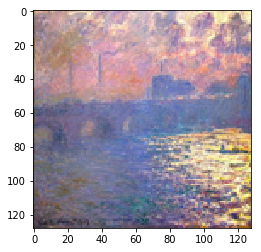

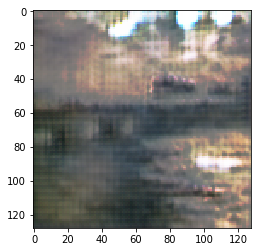

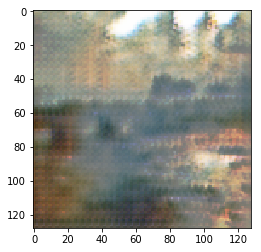

In [26]:
test_image(paintings_addr[27])

In [15]:
def photo2monet(photo_addr):
    img = Image.open(photo_addr)
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    paint_var = F(img_var)
    paint = paint_var.data.cpu().numpy()
    paint = paint[0].transpose(1, 2, 0)
    paint = (paint + 1)/2
    plt.figure()
    plt.imshow(paint)

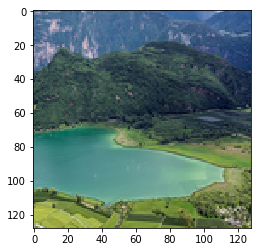

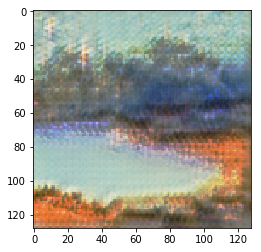

In [27]:
photo2monet(photos_addr[2900])

## Thank you so much for going through this notebook! Hope you had fun

Email: prateekdbst@gmail.com
<br>
Github: https://github.com/prateekmalhotra
<br>
Reddit: u/PhonyPhantom